## Creating a Model

In [2]:
import pandas as pd

df = pd.read_parquet("../0 - Data/scaled_transactions.pq")
df.head()

,Amount,MCC,Has Chip,Cards Issued,Credit Limit,Year PIN last Changed,Current Age,Retirement Age,Birth Year,Birth Month,...,Card Brand_Visa,Card Type_Debit,Card Type_Debit (Prepaid),Gender_Male,Age Group_26-35,Age Group_36-45,Age Group_46-60,Age Group_60+,Use Chip_Online Transaction,Use Chip_Swipe Transaction
0,130.95,5912,1,2,24295.0,2008,53,66,1966,11,...,True,True,False,False,False,False,True,False,False,False
1,130.95,5912,1,2,21968.0,2014,53,66,1966,11,...,True,True,False,False,False,False,True,False,False,False
2,130.95,5912,1,2,46414.0,2004,53,66,1966,11,...,True,True,False,False,False,False,True,False,False,False
3,130.95,5912,0,1,12400.0,2012,53,66,1966,11,...,True,False,False,False,False,False,True,False,False,False
4,130.95,5912,1,1,28.0,2009,53,66,1966,11,...,False,False,True,False,False,False,True,False,False,False


#### Split the data into training and test

In [3]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

split_date = '2019-10-01 00:00:00'

train_data = df[df['Datetime'] < split_date]
test_data = df[df['Datetime'] >= split_date]

#### Drop the Datetime Column

In [4]:
train_data = train_data.drop(["Datetime"], axis=1)
test_data = test_data.drop(["Datetime"], axis=1)

#### Create X and y Vectors

In [5]:
target_column = 'Is Fraud'

# Separate features and target for the training set
X_train = train_data.drop(target_column, axis=1)
y_train = train_data[target_column]

# Separate features and target for the test set
X_test = test_data.drop(target_column, axis=1)
y_test = test_data[target_column]

#### Train the Model

In [8]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU: Quadro T2000


In [20]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming X_train is your DataFrame and y_train is your target variable

# Convert boolean columns to integers (0 for False, 1 for True)
bool_cols = X_train.select_dtypes(include=['bool']).columns
X_train[bool_cols] = X_train[bool_cols].astype(int)

# Convert all columns to numeric, coercing errors to NaN
X_train = X_train.apply(pd.to_numeric, errors='coerce')

# Handle NaN values (you can choose a different method based on your needs)
X_train.fillna(0, inplace=True)

# Convert your data to PyTorch tensors and move them to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)  # Reshape for binary classification

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 1)  # Output layer for binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

# Initialize the model, loss function, and optimizer
model = SimpleNN().to(device)  # Move model to GPU
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters())  # Adam optimizer

# Train the model
num_epochs = 4
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear gradients
    outputs = model(X_train_tensor)  # Forward pass
    loss = criterion(outputs, y_train_tensor)  # Calculate loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights

    if (epoch + 1) % 1 == 0:  # Print loss every epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.5089
Epoch [2/10], Loss: 0.3531
Epoch [3/10], Loss: 0.1698
Epoch [4/10], Loss: 0.1609
Epoch [5/10], Loss: 0.1612
Epoch [6/10], Loss: 0.1613
Epoch [7/10], Loss: 0.1615
Epoch [8/10], Loss: 0.1616
Epoch [9/10], Loss: 0.1617
Epoch [10/10], Loss: 0.1617


#### Model Predictions

In [21]:
# Convert boolean columns to integers in X_test
bool_cols_test = X_test.select_dtypes(include=['bool']).columns
X_test[bool_cols_test] = X_test[bool_cols_test].astype(int)

# Convert all columns to numeric, coercing errors to NaN
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)

# Move X_test to the same device as the model
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)

# Make predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    y_pred_proba = model(X_test_tensor)  # Forward pass
    y_pred = (y_pred_proba > 0.5).int().cpu().numpy()  # Convert probabilities to binary predictions

#### Test the Predictions

In [22]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9995756859836807


In [23]:
from sklearn.metrics import classification_report

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

c:\Users\samos\PythonEnvironments\.datascience\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\samos\PythonEnvironments\.datascience\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2671415
           1       0.00      0.00      0.00      1134

    accuracy                           1.00   2672549
   macro avg       0.50      0.50      0.50   2672549
weighted avg       1.00      1.00      1.00   2672549



c:\Users\samos\PythonEnvironments\.datascience\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
from sklearn.metrics import roc_auc_score

# Make predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    y_pred_proba = model(X_test_tensor)  # Forward pass
    y_pred_proba = y_pred_proba.cpu().numpy()  # Move predictions to CPU and convert to NumPy

# Calculate the ROC-AUC score using the probability predictions
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc}")

ROC-AUC Score: 0.49999775399928503


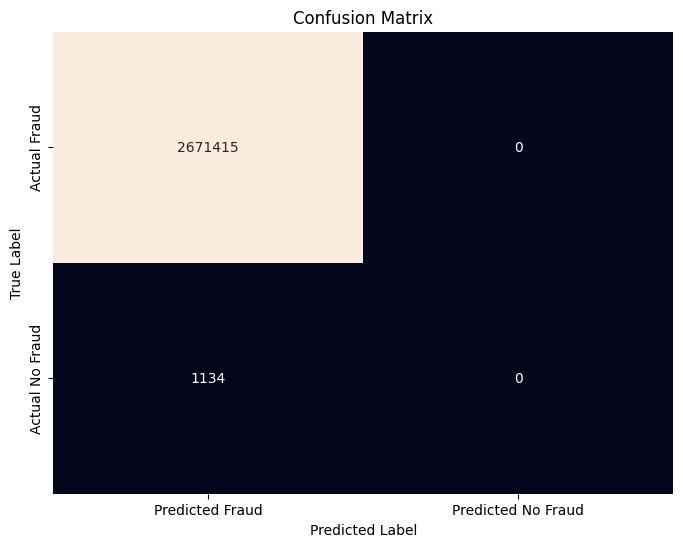

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=['Actual Fraud', 'Actual No Fraud'], columns=['Predicted Fraud', 'Predicted No Fraud'])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Evaluation

